In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import datetime
import dataloader as module_data
import model.callback as module_callback
import model.metric as module_metric
import model.loss as module_loss
import model as module_arch
import argparse
import json
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import os
import utils
from shutil import copy2
from tensorflow.python.client import device_lib

def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])


def train(config_name):
    config = json.load(open(config_name))
    tf.random.set_seed(config['seed'])

    strategy = tf.distribute.MirroredStrategy([x.name for x in device_lib.list_local_devices() if 'device:CPU' in x.name or 'device:GPU' in x.name])
    
    with strategy.scope():
        model = get_instance(module_arch, 'arch', config)

        try:
            model.set_loss(get_instance(module_loss, 'loss', config))
        except:
            model.set_loss(config['loss'])

        for metric in config['metrics']:
            try:
                model.add_metric(
                    getattr(module_metric, metric['type'])(model, **metric['args']))
            except:
                model.add_metric(metric)

        model.set_optimizer(get_instance(
            keras.optimizers, 'optimizer', config))

        if config["restore"] is not None and config["restore"]["continue"]:
            restore = config["restore"]
            uniq = restore["dir"]
            logdir = f"logs/fit/{config['name']}/{uniq}"

            if restore["step"] == "last":
                check_point_name = tf.train.latest_checkpoint(f"{logdir}/checkpoints/")
            else:
                epoch = np.int(restore["step"])
                check_point_name = f"{logdir}/checkpoints/cp-{epoch}.ckpt"
            model.model.load_weights(check_point_name)

        if config["restore"] is None or not config["restore"]["overwrite"]:
            uniq = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            logdir = f"logs/fit/{config['name']}/{uniq}"
            try:
                os.makedirs(logdir)
            except:
                pass

        copy2(config_name, os.path.join(logdir, 'config.json'))
        batch_size = config['trainer']['batch_size']
        checkpoint_dir = os.path.join(logdir, 'checkpoints')


        for callback in config['callbacks']:
            callback_logdir = None
            callback_name = callback['type']
            if 'format' in callback['args']:
                frmt = callback['args']['format']
                del callback['args']['format']
                if callback_name == 'ModelCheckpoint':
                    callback_logdir = os.path.join(checkpoint_dir, frmt)
                else:
                    callback_logdir = os.path.join(logdir, frmt)

            # predefined callback from keras.callbacks
            if callback_name in dir(keras.callbacks):
                if callback_logdir:
                    model.add_callback(
                        getattr(keras.callbacks, callback_name)(callback_logdir, **callback['args']))
                else:
                    model.add_callback(
                        getattr(keras.callbacks, callback_name)(**callback['args']))
            # custom callback from model.callbacks pacakgage
            else:
                if 'callback' in callback['args']:
                    internal_callback = getattr(utils, callback['args']['callback'])
                    del callback['args']['callback']
                else:
                    internal_callback = None

                model.add_callback(
                    getattr(module_callback, callback_name)(model=model,
                                                            logdir=callback_logdir,
                                                            callback= internal_callback,
                                                            batch_size=batch_size,
                                                            checkpoint_dir=checkpoint_dir,
                                                            **callback['args']
                                                           ))

#         model.set_class_weight([1. / config["class_weight"], 1])
        model.compile()
    
    dataloader = get_instance(module_data, 'dataloader', config)

    history = model.train(dataloader.train,
                          dataloader.valid,
                          dataloader.test,
                          **config["trainer"])
    return history

In [2]:
config_file = "config/retain_toyset_with_mask.json"
model, dataloader = train(config_file)

W1113 14:00:32.243844 139830181177152 cross_device_ops.py:1168] There is non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
W1113 14:00:32.817613 139830181177152 deprecation.py:323] From /home/abalak8/.local/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3868: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1113 14:00:35.891628 139830181177152 distributed_training_utils.py:223] `histogram_freq` in the TensorBoard callback is not supported when using DistributionStrategy. Setting `histogram_freq` to `0`.
W1113 14:00:36.127501 139830181177152 summary_ops_v2.py:1110] Model failed to serialize as JSON. Ignoring... ('Not JSON Serializable:', b'\n\x08NotEqual\x12\x08NotEqual\x1a\x07input_1\x1a\nNotEqual/y*\x07\n\x01T\x12\x020\x01')


Train on 36 steps, validate on 4 steps
Epoch 1/2
35/36 [============================>.] - ETA: 0s - loss: 0.6903 - binary_accuracy: 0.5593
Epoch 00001: val_roc improved from -inf to 0.05233, saving model to logs/fit/RETAIN_toyset_masked/20191113-140033/checkpoints/best.ckpt
36/36 [==============================] - 12s 347ms/step - loss: 0.6901 - binary_accuracy: 0.5607 - val_loss: 0.6816 - val_binary_accuracy: 0.6530
Epoch 2/2
33/36 [==========================>...] - ETA: 0s - loss: 0.6670 - binary_accuracy: 0.6487

W1113 14:00:52.900978 139830181177152 training_arrays.py:309] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches (in this case, 72 batches). You may need to use the repeat() function when building your dataset.



Epoch 00002: val_roc improved from 0.05233 to 0.08721, saving model to logs/fit/RETAIN_toyset_masked/20191113-140033/checkpoints/best.ckpt
35/36 [============================>.] - ETA: 0s - loss: 0.6650 - binary_accuracy: 0.6510

TypeError: 'History' object is not iterable

In [25]:
tf.train.latest_checkpoint("logs/fit/RETAIN_HDD/20191012-104155/checkpoints/")

'logs/fit/RETAIN_HDD/20191012-104155/checkpoints/cp-200.ckpt'

In [31]:
modelB = model
np.alltrue(modelB.Wa.get_weights()[0] == modelA.Wa.get_weights()[0])

True

In [32]:
np.alltrue(modelB.Wa.get_weights()[1] == modelA.Wa.get_weights()[1])

True

In [33]:
np.alltrue(modelB.Wb.get_weights()[0] == modelA.Wb.get_weights()[0])

True

In [34]:
np.alltrue(modelB.Wb.get_weights()[1] == modelA.Wb.get_weights()[1])

True

In [35]:
np.alltrue(modelB.Wc.get_weights()[0] == modelA.Wc.get_weights()[0])

True

In [36]:
np.alltrue(modelB.Wc.get_weights()[1] == modelA.Wc.get_weights()[1])

True

In [23]:
modelA = model
modelA.Wa.get_weights()[0]

array([[ 1.0041709 ],
       [ 0.696858  ],
       [-0.6414719 ],
       [ 0.24650587],
       [ 0.6046004 ],
       [ 0.04480207],
       [ 0.781792  ],
       [-0.7512134 ],
       [ 0.00526177],
       [ 0.74700516],
       [-0.8989994 ],
       [ 0.12066373],
       [-0.7553958 ],
       [-0.68922925],
       [ 0.5063263 ],
       [-0.6467352 ],
       [-0.05014832],
       [-0.36592248],
       [ 0.44584894],
       [ 0.47845986],
       [ 0.8411097 ],
       [-0.6265615 ],
       [-0.03946459],
       [-0.6287142 ],
       [-0.35207695],
       [-0.2656605 ],
       [-0.53217137],
       [-0.02602675],
       [ 0.46947107],
       [-0.45156282],
       [-0.39143065],
       [ 0.7186504 ],
       [-0.4933359 ],
       [ 0.24510817],
       [-0.3109455 ],
       [-0.25213006],
       [-0.69698775],
       [-0.6631964 ],
       [ 0.4628349 ],
       [-0.5554229 ],
       [-0.47144377],
       [ 0.53710693],
       [ 0.3056898 ],
       [-0.41162077],
       [ 0.45652065],
       [-0

In [61]:
model.model.load_weights(my_path)

In [62]:
model(X)

<tf.Tensor: id=272383, shape=(5, 1), dtype=float32, numpy=
array([[0.27562103],
       [0.5970974 ],
       [0.5781567 ],
       [0.64718854],
       [0.40662736]], dtype=float32)>

In [57]:
my_path

'logs/fit/RETAIN_toyset_masked/20191011-160236/checkpoints/best.ckpt'

In [63]:
model.model.predict?

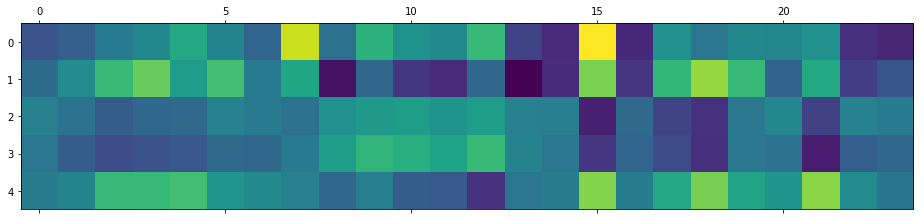

In [4]:
import matplotlib.pyplot as plt
plt.matshow(model.get_contribution_coefficients(X)[0].T)

In [6]:
model.get_contribution(X)[0].shape

(24, 5)

In [29]:
X = dataloader.train.xy[0][:5]
model(X)

<tf.Tensor: id=229841, shape=(5, 1), dtype=float32, numpy=
array([[0.495444 ],
       [0.5060141],
       [0.5103357],
       [0.5183436],
       [0.514245 ]], dtype=float32)>

In [7]:
import pickle

In [9]:
pickle.load(open("logs/fit/RETAIN_toyset_masked/20191011-164713/heatmaps/raw.pkl", "rb"))['names']

array([b'datapoint: 1', b'datapoint: 24', b'datapoint: 25',
       b'datapoint: 29', b'datapoint: 31', b'datapoint: 49',
       b'datapoint: 55', b'datapoint: 56', b'datapoint: 73',
       b'datapoint: 77'], dtype='|S15')

In [66]:
vals = {'x': x, 'y': y}

In [68]:
pickle.dump(vals, open("test.pkl", "wb"))

In [72]:
pickle.load(open("test.pkl", "rb"))['y'] == y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [37]:
np.int("10")

10